In [16]:
from tensorflow import keras
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import os
import numpy as np
import pandas as pd

import sys

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

import matplotlib.pyplot as plt

In [2]:
# IMPORT EXPERIMENTS DATA
results_folder = os.getcwd()
csv_details = "EXPERIMENTS.csv"

exp_details = pd.read_csv(results_folder+"/"+csv_details)

content = os.listdir(results_folder)
exp_dirs = [d for d in content if os.path.isdir(d)][1:]
exp_dirs = sorted(exp_dirs, key=lambda x: int(x.split("_")[0]))

In [63]:
# MODELS
root = "C:/0_thesis/3_experiment/"
models_rgb = []
models_rgb.append(os.path.join(root, "models/rgb_no_alpha/model_4"))
models_rgb.append(os.path.join(root, "models/rgb_alpha05/model_4"))
models_rgb.append(os.path.join(root, "models/rgb_alpha1/model_4"))

models_gray = []
models_gray.append(os.path.join(root, "models/gray_no_alpha/model_4"))
models_gray.append(os.path.join(root, "models/gray_alpha05/model_4"))
models_gray.append(os.path.join(root, "models/gray_alpha1/model_4"))

models = models_rgb + models_gray
models_names = []
for model_path in models:
    models_names.append(model_path.split("/")[-2])

# PREDICT ON ALL MODELS

In [ ]:
def predict(model_path, images_path, colormode):
    # Load model
    model = keras.models.load_model(model_path)

    # Predict on each image
    img_size = 256
    filenames = os.listdir(images_path)

    ages = []
    genders = []

    for filename in filenames:
        if colormode in filename:
            filepath = images_path+"/"+filename
        
            img = tf.keras.utils.load_img(filepath, target_size = (img_size, img_size), color_mode=colormode)
            img = tf.keras.utils.img_to_array(img)
            img = img * (1./255)
            img = tf.expand_dims(img, axis = 0)
            prediction = model.predict(img)
            prediction = np.round(prediction)
            age_pred = int(prediction[0])
            ages.append(age_pred)
            gender_pred = "male" if prediction[1] == 0 else "female"
            genders.append(gender_pred)

    # Analysis
    age_avg = sum(ages)/len(ages)
    #print("Max age: ", max(ages))
    #print("Min age: ", min(ages))
    #print("Average: ", age_avg)
    #print("Most gender: ", max(set(genders), key=genders.count))

    final_age = np.round(age_avg)
    final_gender = max(set(genders), key=genders.count)

    return final_age, final_gender

In [ ]:
# DATAFRAMES: 1 WITH PREDICTED AGE, 1 WITH PREDICTED GENDER 
df_age = pd.DataFrame(exp_dirs, columns = ['DIRNAME'] )
df_age['ID'] = exp_details['ID']
df_age['BEHAVIOR'] = exp_details['BEHAVIOR']
df_age['AGE'] = exp_details['AGE']


df_gender = pd.DataFrame(exp_dirs, columns = ['DIRNAME'] )
df_gender['ID'] = exp_details['ID']
df_gender['BEHAVIOR'] = exp_details['BEHAVIOR']
df_gender['GENDER'] = exp_details['GENDER']

In [ ]:
# PREDICT AND SAVE IN DATAFRAMES
for experiment in exp_dirs:
    print("EXPERIMENT: ", experiment)
    images_path = results_folder+"/"+experiment+"/photos/"
    row = df_age[df_age['DIRNAME'] == experiment].index
    
    for model_path in models_rgb:
        age, gender = predict(model_path, images_path, colormode="rgb")
        model = model_path.split("/")[-2]
        df_age.loc[row, model] = age
        df_gender.loc[row, model] = gender

    for model_path in models_gray:
        age, gender = predict(model_path, images_path, colormode="grayscale")
        model = model_path.split("/")[-2]
        df_age.loc[row, model] = age
        df_gender.loc[row, model] = gender

In [ ]:
df_age.to_csv("age_prediction.csv", index=False)
df_gender.to_csv("gender_prediction.csv", index=False)

## BALANCED MODELS

In [ ]:
'''
temp_root = "C:/0_thesis/2_model/TESTING/BALANCE/"
models_rgb = []
models_rgb.append(os.path.join(temp_root, "19fold/model_4"))
models_rgb.append(os.path.join(temp_root, "20netto/model_4"))
models_rgb.append(os.path.join(temp_root, "20pepper05/model_4"))
models_gray = []
models_gray.append(os.path.join(temp_root, "19foldgray/model_4"))
models_gray.append(os.path.join(temp_root, "20nettogray/model_4"))
models_gray.append(os.path.join(temp_root, "20pepper05gray/model_4"))

# DATAFRAMES: 1 WITH PREDICTED AGE, 1 WITH PREDICTED GENDER 
df_balance_age = pd.DataFrame(exp_dirs, columns = ['DIRNAME'] )
df_balance_age['ID'] = exp_details['ID']
df_balance_age['BEHAVIOR'] = exp_details['BEHAVIOR']
df_balance_age['AGE'] = exp_details['AGE']

df_balance_gender = pd.DataFrame(exp_dirs, columns = ['DIRNAME'] )
df_balance_gender['ID'] = exp_details['ID']
df_balance_gender['BEHAVIOR'] = exp_details['BEHAVIOR']
df_balance_gender['GENDER'] = exp_details['GENDER']

# PREDICT AND SAVE IN DATAFRAMES
for experiment in exp_dirs:
    print("EXPERIMENT: ", experiment)
    images_path = results_folder+"/"+experiment+"/photos/"
    row = df_balance_age[df_balance_age['DIRNAME'] == experiment].index
    
    for model_path in models_rgb:
        age, gender = predict(model_path, images_path, colormode="rgb")
        model = model_path.split("/")[-2]
        df_balance_age.loc[row, model] = age
        df_balance_gender.loc[row, model] = gender

    for model_path in models_gray:
        age, gender = predict(model_path, images_path, colormode="grayscale")
        model = model_path.split("/")[-2]
        df_balance_age.loc[row, model] = age
        df_balance_gender.loc[row, model] = gender
        
df_balance_age.to_csv("balance_age_prediction.csv", index=False)
df_balance_gender.to_csv("belance_gender_prediction.csv", index=False)
'''

# ANALYSIS

In [7]:
age_ranges = {'experiment': [range(0, 18), range(18, 30), range(30, 40), range(40, 50), 
                             range(50, 60), range(60, 70), range(70, 117)],
              'paper2019': [range(0, 16), range(16, 30), range(30, 50), range(50, 117)],
              'generations': [range(0, 11), range(11, 27), range(27, 43), range(43, 59), range(59, 78), range(78, 95)],
              'paper_bari': [range(0, 26), range(26, 41), range(41, 61), range(61, 120)]}

def get_group_from_age(age, age_groups):
    for i, r in enumerate(age_groups):
        if age in r:
            return i
    return None

def get_groups_from(ages):
    age_groups = dict.fromkeys(age_ranges)
    for group_name in age_ranges.keys():
        age_groups[group_name] = []
        for age in ages:
            age_groups[group_name].append(get_group_from_age(age, age_ranges[group_name]))
    return age_groups

## Accuracy, MAE, precision, recall, F1-score

In [8]:
df_age = pd.read_csv("age_prediction.csv", index_col=0)
df_gender = pd.read_csv("gender_prediction.csv", index_col=0)
#df_age = pd.read_csv("balance_age_prediction.csv")
#df_gender = pd.read_csv("belance_gender_prediction.csv")

In [9]:
# ACCURACY ON GENDER
gender_mapper = {'male': 0, 'female': 1}
df_gender = df_gender.replace({"GENDER": gender_mapper})

print("ACCURACY -- GENDER")

models = models_rgb + models_gray

for model_path in models:
    model = model_path.split("/")[-2]
    df_gender = df_gender.replace({model: gender_mapper})
    accuracy = accuracy_score(df_gender["GENDER"], df_gender[model])
    print(model+": ", accuracy)

ACCURACY -- GENDER
rgb_no_alpha:  0.9516129032258065
rgb_alpha05:  0.8709677419354839
rgb_alpha1:  0.8790322580645161
gray_no_alpha:  0.9193548387096774
gray_alpha05:  0.8629032258064516
gray_alpha1:  0.8467741935483871


In [10]:
# true age groups
age_groups = get_groups_from(df_age["AGE"].tolist())

In [11]:
print("ACCURACY -- AGE GROUP")

models = models_rgb + models_gray

# for every model
for model_path in models:
    model = model_path.split("/")[-2]
    print("------"+model+"-------")
    # for every age_ranges
    pred_age_groups = get_groups_from(df_age[model].tolist())
    for group_name in age_ranges.keys():
        accuracy = accuracy_score(age_groups[group_name], pred_age_groups[group_name])
        print(group_name+":",np.round(accuracy,2))

ACCURACY -- AGE GROUP
------rgb_no_alpha-------
experiment: 0.64
paper2019: 0.71
generations: 0.68
paper_bari: 0.68
------rgb_alpha05-------
experiment: 0.45
paper2019: 0.61
generations: 0.44
paper_bari: 0.52
------rgb_alpha1-------
experiment: 0.35
paper2019: 0.49
generations: 0.4
paper_bari: 0.46
------gray_no_alpha-------
experiment: 0.65
paper2019: 0.73
generations: 0.61
paper_bari: 0.6
------gray_alpha05-------
experiment: 0.48
paper2019: 0.63
generations: 0.45
paper_bari: 0.51
------gray_alpha1-------
experiment: 0.42
paper2019: 0.5
generations: 0.48
paper_bari: 0.48


In [12]:
from sklearn.metrics import mean_absolute_error

print("MAE -- AGE")

models = models_rgb + models_gray

mae = []
for model_path in models:
    model = model_path.split("/")[-2]
    mae.append(mean_absolute_error(y_true=df_age["AGE"].tolist(), y_pred=df_age[model].tolist()))
    print(model+": ", mae[-1])

MAE -- AGE
rgb_no_alpha:  4.596774193548387
rgb_alpha05:  8.290322580645162
rgb_alpha1:  11.290322580645162
gray_no_alpha:  5.274193548387097
gray_alpha05:  6.467741935483871
gray_alpha1:  8.67741935483871


# Indexes of wrong predictions

In [94]:
pred_age_groups = get_groups_from(df_age["gray_no_alpha"].tolist())['experiment']
age_groups = get_groups_from(df_age["AGE"].tolist())['experiment']
genders = df_gender['GENDER'].tolist()
pred_genders = df_gender["gray_no_alpha"].tolist()
tot_experiments = int(len(genders)/2)
tot_predictions = tot_experiments*2

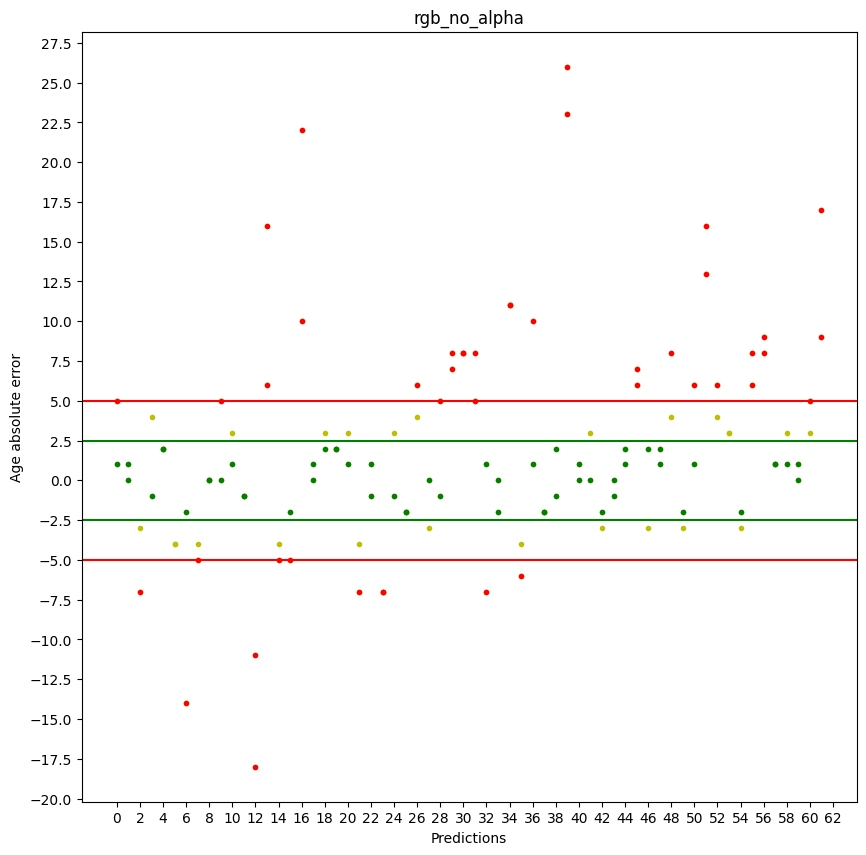

<Figure size 100x1000 with 0 Axes>

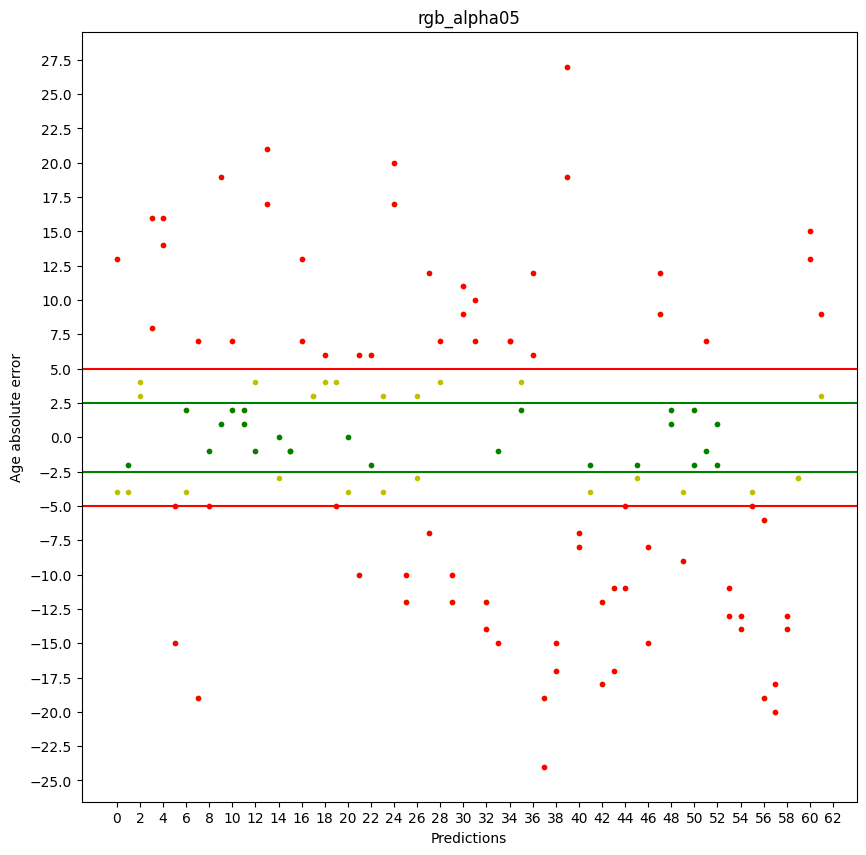

<Figure size 100x1000 with 0 Axes>

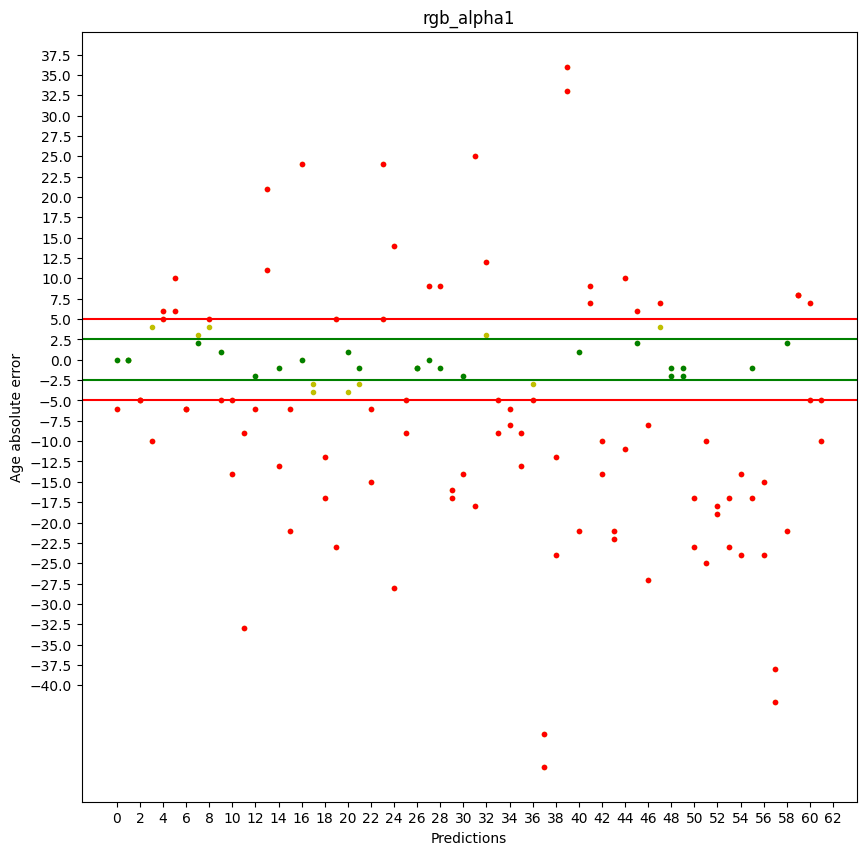

<Figure size 100x1000 with 0 Axes>

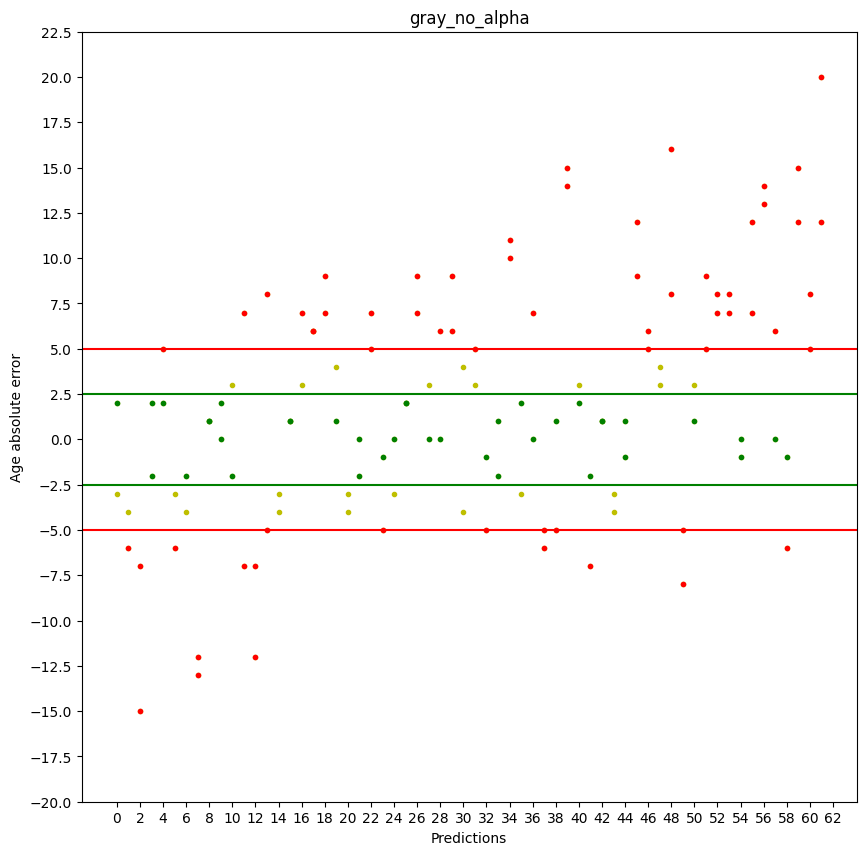

<Figure size 100x1000 with 0 Axes>

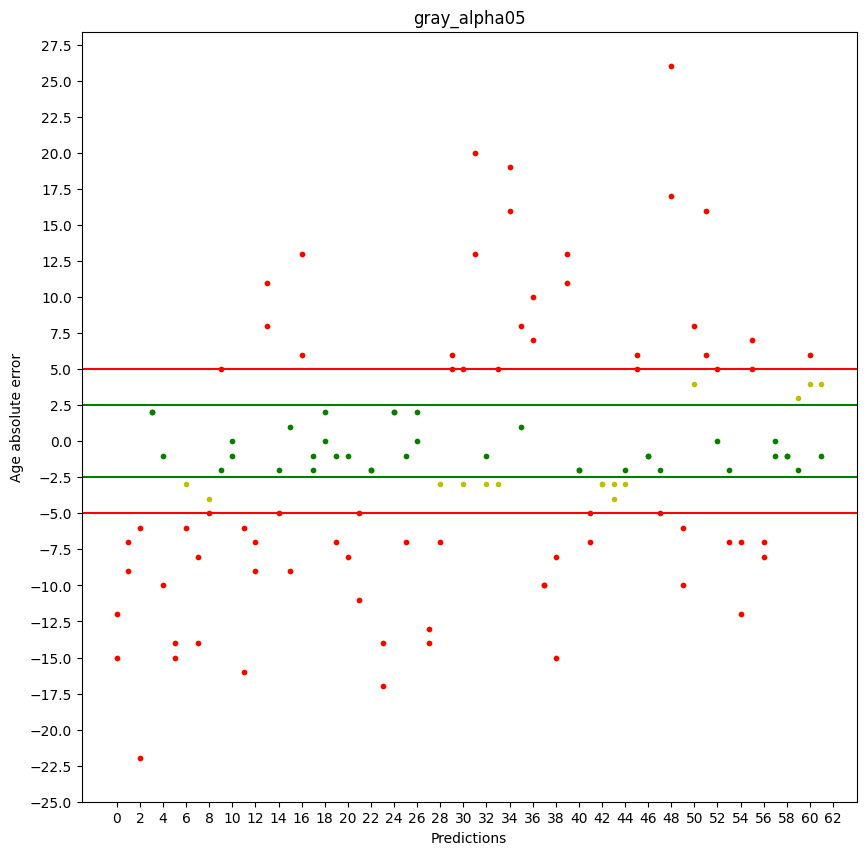

<Figure size 100x1000 with 0 Axes>

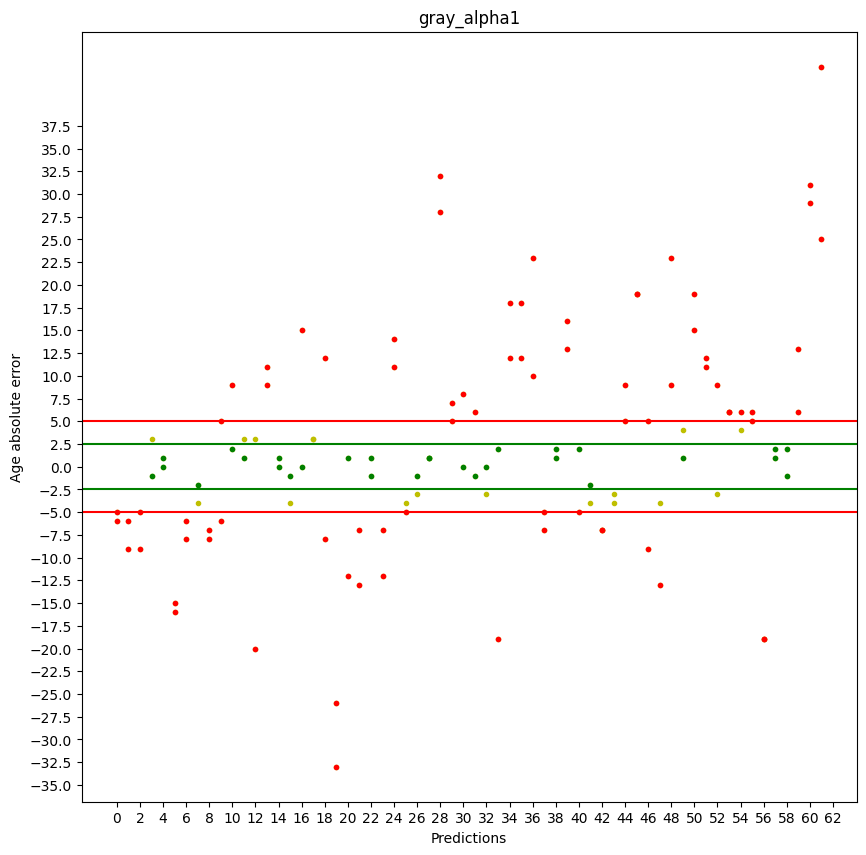

<Figure size 100x1000 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt

for model in models_names:
    diff_age = df_age["AGE"] - df_age[model]
    exps = df_age['ID']

    # y_min
    y_min = min(diff_age)
    for i in range(0, 40, 5):
        if -i >= min(diff_age):
            y_min = -i
    y_min = y_min-5
    # y_max
    y_max = max(diff_age)
    for i in range(0, 40, 5):
        if i <= max(diff_age):
            y_max = i
    y_max = y_max+5
    
    # points with error between -5 and -2.5 or 2.5 and 5
    plt.plot(exps, diff_age, 'yo', markersize=3)

    # error less than -5 or more than 5: red points
    plt.axhline(y = 5, color = 'r')
    plt.axhline(y = -5, color = 'r')
    diff_age_red = []
    exps_red = []
    for i in range(len(diff_age)):
        if diff_age[i] <= -5 or diff_age[i] >= 5:
            diff_age_red.append(diff_age[i])
            exps_red.append(exps[i])
    plt.plot(exps_red, diff_age_red, 'ro', markersize=3)

    # error between -2.5 and 2.5: green points
    plt.axhline(y = 2.5, color = 'g')
    plt.axhline(y = -2.5, color = 'g')
    diff_age_green = []
    exps_green = []
    for i in range(len(diff_age)):
        if diff_age[i] >= -2.5 and diff_age[i] <= 2.5:
            diff_age_green.append(diff_age[i])
            exps_green.append(exps[i])
    plt.plot(exps_green, diff_age_green, 'go', markersize=3)

    plt.xticks(np.arange(min(exps), max(exps)+2, 2))
    plt.yticks(np.arange(y_min, y_max, 2.5))

    plt.xlabel('Predictions')
    plt.ylabel('Age absolute error')
    plt.title(model)
    fig = plt.figure(figsize=(1, 10))
    plt.show()

## GODSPEED

Explicit: true; false age-group/younger; false age-group/older or wrong gender

Implicit: true; false age-group/younger; false age-group/older or wrong gender

In [16]:
# EXPLICIT
id_true_pred = []
id_younger_pred = []
id_older_pred = [] # or wrong gender
tot_experiments = len(age_groups)

for i in range(tot_experiments):
    if df_age.iloc[i].BEHAVIOR == 'explicit':
        exp_id = df_age.iloc[i].ID
        if genders[i] != pred_genders[i] or pred_age_groups[i] > age_groups[i]:
            id_older_pred.append(exp_id)
        elif pred_age_groups[i] < age_groups[i]:
            id_younger_pred.append(exp_id)
        else:
            id_true_pred.append(exp_id)
            
print("All EXPLICIT experiments are considered: ", (len(id_older_pred)+len(id_younger_pred)+len(id_true_pred))==(tot_experiments/2))

print("Id experiments with true predictions: ", id_true_pred)
print("Id experiments with younger predictions: ", id_younger_pred)
print("Id experiments with older predictions or wrong gender: ", id_older_pred)

All EXPLICIT experiments are considered:  True
Id experiments with true predictions:  [0, 1, 4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 23, 24, 25, 26, 28, 31, 33, 35, 36, 37, 40, 41, 42, 43, 44, 46, 47, 49, 50, 51, 54, 57]
Id experiments with younger predictions:  [29, 34, 39, 45, 48, 52, 53, 55, 56, 59, 60, 61]
Id experiments with older predictions or wrong gender:  [2, 3, 7, 12, 15, 21, 22, 27, 30, 32, 38, 58]


In [17]:
# IMPLICIT
id_true_pred = []
id_younger_pred = []
id_older_pred = [] # or wrong gender
tot_experiments = len(age_groups)

for i in range(tot_experiments):
    if df_age.iloc[i].BEHAVIOR == 'implicit':
        exp_id = df_age.iloc[i].ID
        if genders[i] != pred_genders[i] or pred_age_groups[i] > age_groups[i]:
            id_older_pred.append(exp_id)
        elif pred_age_groups[i] < age_groups[i]:
            id_younger_pred.append(exp_id)
        else:
            id_true_pred.append(exp_id)
            
print("All IMPLICIT experiments are considered: ", (len(id_older_pred)+len(id_younger_pred)+len(id_true_pred))==(tot_experiments/2))

print("Id experiments with true predictions: ", id_true_pred)
print("Id experiments with younger predictions: ", id_younger_pred)
print("Id experiments with older predictions or wrong gender: ", id_older_pred)

All IMPLICIT experiments are considered:  True
Id experiments with true predictions:  [3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 19, 20, 23, 24, 25, 28, 30, 31, 33, 37, 38, 40, 41, 42, 43, 44, 46, 47, 50, 51, 54, 58, 60]
Id experiments with younger predictions:  [0, 18, 26, 29, 34, 36, 39, 45, 48, 52, 53, 55, 56, 59, 61]
Id experiments with older predictions or wrong gender:  [1, 2, 7, 11, 14, 21, 22, 27, 32, 35, 49, 57]


## TRUST

Considering the order of submission of the types of questionnaires.

## E+I

In [95]:
# EXPLICIT first behavior
id_true_pred = []
id_younger_pred = []
id_older_pred = [] # or wrong gender
tot_experiments = len(age_groups)

for i in range(tot_experiments):
    if '_1_e' in df_age.iloc[i].DIRNAME:
        exp_id = df_age.iloc[i].ID
        if genders[i] != pred_genders[i] or pred_age_groups[i] > age_groups[i]:
            id_older_pred.append(exp_id)
        elif pred_age_groups[i] < age_groups[i]:
            id_younger_pred.append(exp_id)
        else:
            id_true_pred.append(exp_id)
            
print("Id experiments with true predictions: ", id_true_pred)
print("Id experiments with younger predictions: ", id_younger_pred)
print("Id experiments with older predictions or wrong gender: ", id_older_pred)

Id experiments with true predictions:  [0, 4, 6, 8, 10, 14, 16, 18, 20, 24, 26, 28, 36, 40, 42, 44, 46, 50, 54]
Id experiments with younger predictions:  [34, 48, 52, 56, 60]
Id experiments with older predictions or wrong gender:  [2, 12, 22, 30, 32, 38, 58]


In [96]:
# IMPLICIT second behavior
id_true_pred_2 = []
id_younger_pred_2 = []
id_older_pred_2 = [] # or wrong gender
tot_experiments = len(age_groups)

for i in range(tot_experiments):
    if '_2_i' in df_age.iloc[i].DIRNAME:
        exp_id = df_age.iloc[i].ID
        if genders[i] != pred_genders[i] or pred_age_groups[i] > age_groups[i]:
            id_older_pred_2.append(exp_id)
        elif pred_age_groups[i] < age_groups[i]:
            id_younger_pred_2.append(exp_id)
        else:
            id_true_pred_2.append(exp_id)

print("Id experiments with true predictions:", id_true_pred_2)
print("Id experiments with younger predictions:", id_younger_pred_2)
print("Id experiments with older predictions or wrong gender:", id_older_pred_2)

Id experiments with true predictions: [4, 6, 8, 10, 12, 16, 20, 24, 28, 30, 38, 40, 42, 44, 46, 50, 54, 58, 60]
Id experiments with younger predictions: [0, 18, 26, 34, 36, 48, 52, 56]
Id experiments with older predictions or wrong gender: [2, 14, 22, 32]


## I+E

In [21]:
# IMPLICIT first behavior
id_true_pred = []
id_younger_pred = []
id_older_pred = [] # or wrong gender
tot_experiments = len(age_groups)

for i in range(tot_experiments):
    if '_1_i' in df_age.iloc[i].DIRNAME:
        exp_id = df_age.iloc[i].ID
        if genders[i] != pred_genders[i] or pred_age_groups[i] > age_groups[i]:
            id_older_pred.append(exp_id)
        elif pred_age_groups[i] < age_groups[i]:
            id_younger_pred.append(exp_id)
        else:
            id_true_pred.append(exp_id)

print("Id experiments with true predictions:", id_true_pred)
print("Id experiments with younger predictions:", id_younger_pred)
print("Id experiments with older predictions or wrong gender:", id_older_pred)

Id experiments with true predictions:  [3, 5, 9, 13, 15, 17, 19, 23, 25, 31, 33, 37, 41, 43, 47, 51]
Id experiments with younger predictions:  [29, 39, 45, 53, 55, 59, 61]
Id experiments with older predictions or wrong gender:  [1, 7, 11, 21, 27, 35, 49, 57]


In [19]:
# EXPLICIT second behavior
id_true_pred_2 = []
id_younger_pred_2 = []
id_older_pred_2 = [] # or wrong gender
tot_experiments = len(age_groups)

for i in range(tot_experiments):
    if '_2_e' in df_age.iloc[i].DIRNAME:
        exp_id = df_age.iloc[i].ID
        if genders[i] != pred_genders[i] or pred_age_groups[i] > age_groups[i]:
            id_older_pred_2.append(exp_id)
        elif pred_age_groups[i] < age_groups[i]:
            id_younger_pred_2.append(exp_id)
        else:
            id_true_pred_2.append(exp_id)

print("Id experiments with true predictions:", id_true_pred_2)
print("Id experiments with younger predictions:", id_younger_pred_2)
print("Id experiments with older predictions or wrong gender:", id_older_pred_2)

Id experiments with true predictions:  [1, 5, 9, 11, 13, 17, 19, 23, 25, 31, 33, 35, 37, 41, 43, 47, 49, 51, 57]
Id experiments with younger predictions:  [29, 39, 45, 53, 55, 59, 61]
Id experiments with older predictions or wrong gender:  [3, 7, 15, 21, 27]


In [20]:
print("All IMPLICIT experiments are considered:", (len(id_older_pred)+len(id_younger_pred)+len(id_true_pred)+len(id_older_pred_2)+len(id_younger_pred_2)+len(id_true_pred_2))==(tot_experiments/2))

All IMPLICIT experiments are considered:  True


In [26]:
print("All IMPLICIT experiments are considered:", (len(id_older_pred)+len(id_younger_pred)+len(id_true_pred)+len(id_older_pred_2)+len(id_younger_pred_2)+len(id_true_pred_2))==(tot_experiments/2))

All IMPLICIT experiments are considered:  True


## Prediction stability

In [31]:
# Where age group or gender was predicted wrong in the experiment session
pred_age_groups = get_groups_from(df_age["gray_no_alpha"].tolist())['experiment']
age_groups = get_groups_from(df_age["AGE"].tolist())['experiment']
genders = df_gender['GENDER'].tolist()
pred_genders = df_gender["gray_no_alpha"].tolist()
tot_experiments = int(len(genders)/2)
tot_predictions = tot_experiments*2

In [59]:
# STABILITY OF ALL PREDICTIONS:
# if predictions of the two parts are equals -> stable
# not considering if predictions are true or wrong 
# so wrong-wrong is stable 
id_diff_pred_age = []
id_diff_pred_gender = []
id_diff_pred = []
for i in range(0, len(age_groups)-1, 2):
    if pred_genders[i] != pred_genders[i+1] or pred_age_groups[i] != pred_age_groups[i+1]:
        id_diff_pred.append(df_gender.iloc[i].ID)
        if pred_genders[i] != pred_genders[i+1]:
            id_diff_pred_gender.append(df_gender.iloc[i].ID)
        if pred_age_groups[i] != pred_age_groups[i+1]:
            id_diff_pred_age.append(df_gender.iloc[i].ID)

In [60]:
print("Number of predictions different in the two parts of experiment:", len(id_diff_pred), "on", tot_experiments)
print("Number of AGE GROUP predictions different in the two parts of experiment:", len(id_diff_pred_age), "on", tot_experiments)
print("Number of GENDER predictions different in the two parts of experiment:", len(id_diff_pred_gender), "on", tot_experiments)

Number of predictions different in the two parts of experiment: 20 on 62
Number of AGE GROUP predictions different in the two parts of experiment: 16 on 62
Number of GENDER predictions different in the two parts of experiment: 4 on 62


In [61]:
# return array of indexes of wrong prediction in only one of the two parts
def clear_id_wrong_pred(id_wrong_pred):
    # get indexes repeated once + numbers of wrong prediction in the same id session
    # = 1 if it was wrong in only one part, 2 if it was wrong in both 
    unique_id_wrong_pred, frequency = np.unique(id_wrong_pred, return_counts = True)

    # keep only if it was wrong in one:
    # this means that prediction was not stable
    indices = np.where(frequency==2)
    return np.delete(unique_id_wrong_pred, indices)


# STABILITY OF WRONG PREDICTIONS
# if predictions of the two parts are: wrong-wrong -> stable
id_wrong_pred = []
id_wrong_pred_gender = []
id_wrong_pred_age = []

# add index of wrong predictions
for i in range(0, len(age_groups)-1):
    # if first prediction is wrong
    if genders[i] != pred_genders[i] or age_groups[i] != pred_age_groups[i]:
        id_wrong_pred.append(df_gender.iloc[i].ID)
        if genders[i] != pred_genders[i]:
            id_wrong_pred_gender.append(df_gender.iloc[i].ID)
        if age_groups[i] != pred_age_groups[i]:
            id_wrong_pred_age.append(df_gender.iloc[i].ID)

# keep index only if one of the two predictions is wrong
# so the other is true and that experiment is not stable
id_single_wrong_pred = clear_id_wrong_pred(id_wrong_pred)
id_single_wrong_pred_age = clear_id_wrong_pred(id_wrong_pred_age)
id_single_wrong_pred_gender = clear_id_wrong_pred(id_wrong_pred_gender)

In [62]:
print("Number of predictions in which only one of the two is wrong:", len(id_single_wrong_pred), "on", tot_experiments)
print("Number of AGE GROUP predictions in which only one of the two is wrong:", len(id_single_wrong_pred_age), "on", tot_experiments)
print("Number of GENDER predictions in which only one of the two is wrong:", len(id_single_wrong_pred_gender), "on", tot_experiments)

Number of predictions in which only one of the two is wrong: 18 on 62
Number of AGE GROUP predictions in which only one of the two is wrong: 15 on 62
Number of GENDER predictions in which only one of the two is wrong: 4 on 62


In [58]:
print(id_diff_pred_age)
print(id_single_wrong_pred_age)
# EXP 2: real_age_group = 1, pred_age_group_1 = 2, pred_age_group_2 = 3
# both wrong so not in id_wrong_pred_age
# but different so in id_diff_pred_age 

[0, 1, 2, 11, 12, 14, 18, 26, 30, 35, 36, 38, 48, 49, 58, 60]
[ 0  1 11 12 14 18 26 30 35 36 38 49 58 60 61]


In [64]:
print("% of AGE GROUP predictions equals in the two parts of experiment:", (1-np.round(len(id_diff_pred_age)/tot_experiments,2))*100)
print("% of GENDER predictions equals in the two parts of experiment:", (1-np.round(len(id_diff_pred_gender)/tot_experiments,2))*100)

% of AGE GROUP predictions equals in the two parts of experiment: 74.0
% of GENDER predictions equals in the two parts of experiment: 94.0
